In [15]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import os
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import json
import cftime
from itertools import product
from cftime import DatetimeNoLeap
import esmvalcore.preprocessor
import xesmf as xe
from xmip.preprocessing import promote_empty_dims, broadcast_lonlat, replace_x_y_nominal_lat_lon, rename_cmip6
from tqdm import tqdm
import dask


def read_in(dir, t_bnds, months, ocean = False, plev=False):
    files = []
    for x in os.listdir(dir):
        files.append(dir + x)
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        if ocean:
            ds = replace_x_y_nominal_lat_lon(rename_cmip6(xr.open_mfdataset(files)))
        else: 
            ds = rename_cmip6(xr.open_mfdataset(files))
    ds = ds.sel(time=slice(t_bnds[0], t_bnds[1]))
    ds = ds.where((ds['time.month'].isin(months)), drop=True)
    ds = ds.sel(y=slice(65,90))
    if plev:
        ds = ds.sel(plev=85000)

    return ds


def sea_ice_mask(in_ds, model, ensemble_member, t_bnds, months, conc_cutoff=95,
                 min_conc_cutoff=15,
                 siconc_dir='/gws/nopw/j04/cpom/aduffey/siconc_regrids/out_siconca/',
                 reverse=False):
       
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        sea_ice = rename_cmip6(xr.open_mfdataset(siconc_dir+'*{m}*{e}*.nc'.format(
                                            m=model, e=ensemble_member)))

    sea_ice = sea_ice.sel(time=slice(t_bnds[0], t_bnds[1]))
    sea_ice = sea_ice.where((sea_ice['time.month'].isin(months)), drop=True)
    sea_ice = sea_ice.sel(y=slice(65,90))

    sea_ice.load()
    in_ds.load()
    
    regridder = xe.Regridder(sea_ice, in_ds, 'bilinear', periodic=True)
    sea_ice = regridder(sea_ice)
    
    if reverse:
        try:
            SI_mask = xr.where(sea_ice['siconc'] < min_conc_cutoff, True, False)
        except:
            SI_mask = xr.where(sea_ice['siconca'] < min_conc_cutoff, True, False)
    else:
        try:
            SI_mask = xr.where(sea_ice['siconc'] > conc_cutoff, True, False)
        except:
            SI_mask = xr.where(sea_ice['siconca'] > conc_cutoff, True, False)
    # resample up to needed time resolution
    SI_mask = SI_mask.reindex(time=in_ds['time'], method='ffill')

    masked_ds = in_ds.where(SI_mask)

    #    print('no siconc data in {}'.format(siconc_dir))
        
    return masked_ds


def process_inversions(dir_ta, dir_tas, region, mod, ens):
    ## region must be 'sea_ice', 'open_ocean' or 'land'
    
    ds_ta = read_in(dir_ta, t_bnds=inversion_time_period, months=winter_months,
                    plev=True)
    
    ds_tas = read_in(dir_tas, t_bnds=inversion_time_period, months=winter_months)
    
    ds_tas['inv_strength'] = ds_ta['ta'] -  ds_tas['tas']

    if region == 'sea_ice':
        ds_tas = sea_ice_mask(ds_tas, mod, ens, 
                         t_bnds=inversion_time_period, 
                         months=winter_months)
    elif region == 'open_ocean':
        ds_tas = sea_ice_mask(ds_tas, mod, ens, 
                         t_bnds=inversion_time_period, 
                         months=winter_months, reverse=True)
    elif region == 'land':
        print('need to implement land masking')
        breakhere
    
    
    #ds_tas['inv_strength'].isel(time=0).plot()
    
    ds_stacked = ds_tas['inv_strength'].stack(z=('x', 'y','time'))
    np.savetxt("{r}_monthly_inversions/{m}_{e}.csv".format(r=region, m=mod, e=ens), 
               ds_stacked.values, delimiter=",")
    print(region +' done')


def process_cloud_ice_fraction(dirs, region, mod, ens):
    ## region must be 'sea_ice', 'open_ocean' or 'land'
    ## dirs is a dict of directories, labelled by variable
    
    ds_ta = read_in(dirs['ta'], t_bnds=inversion_time_period, months=winter_months,
                    plev=True)
    
    ds_tas = read_in(dirs['tas'], t_bnds=inversion_time_period, months=winter_months)

    ds_clivi = read_in(dirs['clivi'], t_bnds=inversion_time_period, months=winter_months)

    ds_clwvi = read_in(dirs['clwvi'], t_bnds=inversion_time_period, months=winter_months)

    #print(ds_tas)
    ds_tas['inv_strength'] = ds_ta['ta'] -  ds_tas['tas']
    ds_tas['ice_fraction'] = ds_clivi['clivi']/ds_clwvi['clwvi']

    if region == 'sea_ice':
        ds_tas = sea_ice_mask(ds_tas, mod, ens, 
                         t_bnds=inversion_time_period, 
                         months=winter_months)
    elif region == 'open_ocean':
        ds_tas = sea_ice_mask(ds_tas, mod, ens, 
                         t_bnds=inversion_time_period, 
                         months=winter_months, reverse=True)
    elif region == 'land':
        print('need to implement land masking')
        breakhere
    
    #print(ds_tas)
    #ds_tas['inv_strength'].isel(time=0).plot()

    ds_stacked = ds_tas.stack(z=('x', 'y','time'))['ice_fraction']
    np.savetxt("{r}_monthly_cloud_ice_fractions/{m}_{e}.csv".format(r=region, m=mod, e=ens), 
               ds_stacked.values, delimiter=",")
    print(region +' done')


def process_cloud(dirs, region, mod, ens):
    ## region must be 'sea_ice', 'open_ocean' or 'land'
    ## dirs is a dict of directories, labelled by variable
    
    ds_clwvi = read_in(dirs['clwvi'], t_bnds=inversion_time_period, months=winter_months)

    #print(ds_tas)
    

    if region == 'sea_ice':
        ds_clwvi = sea_ice_mask(ds_clwvi, mod, ens, 
                         t_bnds=inversion_time_period, 
                         months=winter_months)
    elif region == 'open_ocean':
        ds_clwvi = sea_ice_mask(ds_clwvi, mod, ens, 
                         t_bnds=inversion_time_period, 
                         months=winter_months, reverse=True)
    elif region == 'land':
        print('need to implement land masking')
        breakhere
    
    #print(ds_tas)
    #ds_tas['inv_strength'].isel(time=0).plot()

    ds_stacked = ds_clwvi.stack(z=('x', 'y','time'))['clwvi']
    np.savetxt("{r}_monthly_cloud_clwvi/{m}_{e}.csv".format(r=region, m=mod, e=ens), 
               ds_stacked.values, delimiter=",")
    print(region +' done')

    
def process_hfss(dirs, region, mod, ens):
    ## region must be 'sea_ice', 'open_ocean' or 'land'
    ## dirs is a dict of directories, labelled by variable

    ds_hfss = read_in(dirs['hfss'], t_bnds=inversion_time_period, months=winter_months)


    #print(ds_tas)
    
    if region == 'sea_ice':
        ds_hfss = sea_ice_mask(ds_hfss, mod, ens, 
                         t_bnds=inversion_time_period, 
                         months=winter_months)
    elif region == 'open_ocean':
        ds_hfss = sea_ice_mask(ds_hfss, mod, ens, 
                         t_bnds=inversion_time_period, 
                         months=winter_months, reverse=True)
    elif region == 'land':
        print('need to implement land masking')
        breakhere
    
    #print(ds_tas)
    #ds_tas['inv_strength'].isel(time=0).plot()

    ds_stacked = ds_hfss.stack(z=('x', 'y','time'))['hfss']
    np.savetxt("{r}_monthly_hfss/{m}_{e}.csv".format(r=region, m=mod, e=ens), 
               ds_stacked.values, delimiter=",")
    print(region +' done')


def process_hfss_div_sfcWind(dirs, region, mod, ens):
    ## region must be 'sea_ice', 'open_ocean' or 'land'
    ## dirs is a dict of directories, labelled by variable

    ds_hfss = read_in(dirs['hfss'], t_bnds=inversion_time_period, months=winter_months)
    ds_sfcWind = read_in(dirs['sfcWind'], t_bnds=inversion_time_period, months=winter_months)


    ds_hfss['windscaled_hfss'] = ds_hfss['hfss']/ds_sfcWind['sfcWind']

    #print(ds_tas)
    
    if region == 'sea_ice':
        ds_hfss = sea_ice_mask(ds_hfss, mod, ens, 
                         t_bnds=inversion_time_period, 
                         months=winter_months)
    elif region == 'open_ocean':
        ds_hfss = sea_ice_mask(ds_hfss, mod, ens, 
                         t_bnds=inversion_time_period, 
                         months=winter_months, reverse=True)
    elif region == 'land':
        print('need to implement land masking')
        breakhere
    
    #print(ds_tas)
    #ds_tas['inv_strength'].isel(time=0).plot()

    ds_stacked = ds_hfss.stack(z=('x', 'y','time'))['windscaled_hfss']
    np.savetxt("{r}_monthly_hfss_div_sfcWind/{m}_{e}.csv".format(r=region, m=mod, e=ens), 
               ds_stacked.values, delimiter=",")
    print(region +' done')

    

inversion_time_period = ['1995', '2015']
winter_months = [11, 12, 1, 2, 3]

In [7]:
### test new func:
mod=model='GISS-E2-1-H'
ens=ensemble_member='r1i1p1f2'
paths = ['/badc/cmip6/data/CMIP6/CMIP/NASA-GISS/GISS-E2-1-H/historical/r1i1p1f2/Amon/ta/gn/latest/',
        '/badc/cmip6/data/CMIP6/CMIP/NASA-GISS/GISS-E2-1-H/historical/r1i1p1f2/Amon/tas/gn/latest/',
        '/badc/cmip6/data/CMIP6/CMIP/NASA-GISS/GISS-E2-1-H/historical/r1i1p1f2/Amon/clivi/gn/latest/',
        '/badc/cmip6/data/CMIP6/CMIP/NASA-GISS/GISS-E2-1-H/historical/r1i1p1f2/Amon/clwvi/gn/latest/']

labels = ['ta', 'tas', 'clivi', 'clwvi']
dirs = dict(zip(labels, paths))
dirs

#process_cloud_ice_fraction(dirs=dirs, region='sea_ice', mod=mod, ens=ens)

mod=model='GISS-E2-1-H'
ens=ensemble_member='r1i1p1f2'
paths = ['/badc/cmip6/data/CMIP6/CMIP/NASA-GISS/GISS-E2-1-H/historical/r1i1p1f2/Amon/hfss/gn/latest/']
labels = ['hfss']
dirs = dict(zip(labels, paths))
dirs

{'ta': '/badc/cmip6/data/CMIP6/CMIP/NASA-GISS/GISS-E2-1-H/historical/r1i1p1f2/Amon/ta/gn/latest/',
 'tas': '/badc/cmip6/data/CMIP6/CMIP/NASA-GISS/GISS-E2-1-H/historical/r1i1p1f2/Amon/tas/gn/latest/',
 'clivi': '/badc/cmip6/data/CMIP6/CMIP/NASA-GISS/GISS-E2-1-H/historical/r1i1p1f2/Amon/clivi/gn/latest/',
 'clwvi': '/badc/cmip6/data/CMIP6/CMIP/NASA-GISS/GISS-E2-1-H/historical/r1i1p1f2/Amon/clwvi/gn/latest/'}

In [18]:
os.listdir('/badc/cmip6/data/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/historical/r1i1p1f1/Amon/sfcWind/gn/latest/')

['sfcWind_Amon_GISS-E2-1-G_historical_r1i1p1f1_gn_185001-190012.nc',
 'sfcWind_Amon_GISS-E2-1-G_historical_r1i1p1f1_gn_190101-195012.nc',
 'sfcWind_Amon_GISS-E2-1-G_historical_r1i1p1f1_gn_195101-200012.nc',
 'sfcWind_Amon_GISS-E2-1-G_historical_r1i1p1f1_gn_200101-201412.nc']

In [19]:
### run for GISS:

mod=model='GISS-E2-1-G'
ens=ensemble_member='r1i1p1f1'

paths = ['/badc/cmip6/data/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/historical/r1i1p1f1/Amon/ta/gn/latest/',
        '/badc/cmip6/data/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/historical/r1i1p1f1/Amon/tas/gn/latest/',
        '/badc/cmip6/data/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/historical/r1i1p1f1/Amon/clivi/gn/latest/',
        '/badc/cmip6/data/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/historical/r1i1p1f1/Amon/clwvi/gn/latest/',
        '/badc/cmip6/data/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/historical/r1i1p1f1/Amon/hfss/gn/latest/',
        '/badc/cmip6/data/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/historical/r1i1p1f1/Amon/sfcWind/gn/latest/']

labels = ['ta', 'tas', 'clivi', 'clwvi', 'hfss', 'sfcWind']

dirs = dict(zip(labels, paths))
dirs

#process_cloud(dirs=dirs, region='sea_ice', mod=mod, ens=ens)
#process_inversions(dir_ta=dirs['ta'], dir_tas=dirs['tas'], region='sea_ice', mod=mod, ens=ens)
process_cloud_ice_fraction(dirs, region='sea_ice', mod=mod, ens=ens)
#process_hfss(dirs, region='sea_ice', mod=mod, ens=ens)
#process_hfss_div_sfcWind(dirs, region='sea_ice', mod=mod, ens=ens)

sea_ice done
sea_ice done
sea_ice done
sea_ice done


In [7]:
### make a list of models:
dirs=[]
for x in glob.glob('/badc/cmip6/data/CMIP6/CMIP/*/*/historical/*/Amon/sfcWind/*/latest/'): 
    dirs.append(x)

models = []
for x in dirs:
    model = x.split('/')[7]
    if model not in models:
        models.append(model)
#models

In [3]:
### cloud water processing

### make a list of models:
dirs=[]
for x in glob.glob('/badc/cmip6/data/CMIP6/CMIP/*/*/historical/*/Amon/clwvi/*/latest/'): 
    dirs.append(x)

models = []
for x in dirs:
    model = x.split('/')[7]
    if model not in models:
        models.append(model)


### now run over all models
vars = ['clwvi']

for model in tqdm(models):
    print(model)
    ens_mems_long = os.listdir(glob.glob('/badc/cmip6/data/CMIP6/*/*/{m}/historical/'.format(m=model))[0])
    ens_mems = sorted([idx for idx in ens_mems_long if idx[0].lower() == 'r'.lower()], key=len)
    #DF_multi_ens = pd.DataFrame()
    for ens_mem in ens_mems[0:1]:
        print(ens_mem)
        try:
            paths = []
            for var in vars:
                folder = glob.glob('/badc/cmip6/data/CMIP6/*/*/{m}/historical/{ens}/Amon/{v}/*/latest/'.format(
                                        m=model, ens=ens_mem, v=var))[0]
                paths.append(folder)
            dirs = dict(zip(vars, paths))
        
            ### select processing function from options below:
            process_cloud(dirs=dirs, region='sea_ice', mod=model, ens=ens_mem)
            
        except: 
            print('failed')

  0%|          | 0/51 [00:00<?, ?it/s]

TaiESM1
r1i1p1f1


  2%|▏         | 1/51 [00:07<06:08,  7.37s/it]

sea_ice done
AWI-CM-1-1-MR
r1i1p1f1


  4%|▍         | 2/51 [00:35<16:07, 19.74s/it]

failed
AWI-ESM-1-1-LR
r1i1p1f1


  6%|▌         | 3/51 [01:01<17:49, 22.27s/it]

failed
BCC-CSM2-MR
r1i1p1f1


  8%|▊         | 4/51 [01:10<13:27, 17.19s/it]

sea_ice done
BCC-ESM1
r1i1p1f1


 10%|▉         | 5/51 [01:16<10:03, 13.12s/it]

sea_ice done
CAMS-CSM1-0
r1i1p1f1


 12%|█▏        | 6/51 [01:25<08:56, 11.92s/it]

sea_ice done
FGOALS-f3-L
r1i1p1f1


 14%|█▎        | 7/51 [01:28<06:33,  8.95s/it]

failed
FGOALS-g3
r1i1p1f1


 16%|█▌        | 8/51 [01:39<06:45,  9.44s/it]

sea_ice done
IITM-ESM
r1i1p1f1


 18%|█▊        | 9/51 [01:43<05:28,  7.83s/it]

failed
CanESM5
r1i1p1f1


 20%|█▉        | 10/51 [01:46<04:19,  6.33s/it]

sea_ice done
CanESM5-CanOE
r1i1p2f1


 22%|██▏       | 11/51 [01:49<03:28,  5.22s/it]

sea_ice done
CMCC-CM2-HR4
r1i1p1f1


 24%|██▎       | 12/51 [01:56<03:49,  5.87s/it]

sea_ice done
CMCC-CM2-SR5
r1i1p1f1


 25%|██▌       | 13/51 [02:02<03:41,  5.84s/it]

sea_ice done
CMCC-ESM2
r1i1p1f1


 27%|██▋       | 14/51 [02:07<03:32,  5.75s/it]

sea_ice done
CNRM-CM6-1
r1i1p1f2


 29%|██▉       | 15/51 [02:12<03:14,  5.42s/it]

sea_ice done
CNRM-ESM2-1
r1i1p1f2


 31%|███▏      | 16/51 [02:16<02:58,  5.11s/it]

sea_ice done
E3SM-1-0
r1i1p1f1


 33%|███▎      | 17/51 [02:37<05:30,  9.73s/it]

sea_ice done
E3SM-1-1
r1i1p1f1


 35%|███▌      | 18/51 [03:13<09:44, 17.72s/it]

sea_ice done
E3SM-1-1-ECA
r1i1p1f1


 37%|███▋      | 19/51 [03:29<09:09, 17.18s/it]

sea_ice done
EC-Earth3
r1i1p1f1


 39%|███▉      | 20/51 [05:30<24:53, 48.19s/it]

sea_ice done
EC-Earth3-AerChem
r1i1p1f1


 41%|████      | 21/51 [06:15<23:43, 47.45s/it]

sea_ice done
EC-Earth3-CC
r1i1p1f1


 43%|████▎     | 22/51 [07:00<22:34, 46.70s/it]

sea_ice done
EC-Earth3-Veg-LR
r1i1p1f1


 45%|████▌     | 23/51 [07:36<20:11, 43.26s/it]

sea_ice done
FIO-ESM-2-0
r1i1p1f1


 47%|████▋     | 24/51 [07:41<14:24, 32.02s/it]

sea_ice done
MPI-ESM-1-2-HAM
r1i1p1f1


 49%|████▉     | 25/51 [07:50<10:53, 25.14s/it]

sea_ice done
INM-CM4-8
r1i1p1f1


 51%|█████     | 26/51 [07:57<08:09, 19.57s/it]

sea_ice done
INM-CM5-0
r1i1p1f1


 53%|█████▎    | 27/51 [08:02<06:07, 15.31s/it]

sea_ice done
IPSL-CM6A-LR
r1i1p1f1


/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
 55%|█████▍    | 28/51 [08:07<04:38, 12.10s/it]

sea_ice done
KIOST-ESM
r1i1p1f1


 57%|█████▋    | 29/51 [08:13<03:48, 10.40s/it]

sea_ice done
MIROC-ES2L
r1i1p1f2


 59%|█████▉    | 30/51 [08:16<02:46,  7.95s/it]

failed
MIROC6
r1i1p1f1


 61%|██████    | 31/51 [08:21<02:22,  7.12s/it]

sea_ice done
HadGEM3-GC31-LL
r1i1p1f3


 63%|██████▎   | 32/51 [08:26<02:01,  6.39s/it]

sea_ice done
HadGEM3-GC31-MM
r1i1p1f3


 65%|██████▍   | 33/51 [08:42<02:50,  9.48s/it]

sea_ice done
UKESM1-0-LL
r1i1p1f2


 67%|██████▋   | 34/51 [08:47<02:18,  8.15s/it]

sea_ice done
MPI-ESM1-2-HR
r1i1p1f1


 69%|██████▊   | 35/51 [09:11<03:24, 12.81s/it]

sea_ice done
MPI-ESM1-2-LR
r1i1p1f1


 71%|███████   | 36/51 [09:21<02:59, 11.99s/it]

sea_ice done
MRI-ESM2-0
r1i1p1f1


 73%|███████▎  | 37/51 [09:27<02:21, 10.13s/it]

sea_ice done
GISS-E2-1-G
r1i1p1f1


 75%|███████▍  | 38/51 [09:35<02:05,  9.69s/it]

failed
GISS-E2-1-H
r1i1p1f1


 76%|███████▋  | 39/51 [09:43<01:48,  9.07s/it]

failed
CESM2
r1i1p1f1


/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'clwvi' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
 78%|███████▊  | 40/51 [09:49<01:29,  8.15s/it]

failed
CESM2-FV2
r1i1p1f1


/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'clwvi' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
 80%|████████  | 41/51 [09:54<01:12,  7.25s/it]

sea_ice done
CESM2-WACCM
r1i1p1f1


/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'clwvi' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
 82%|████████▏ | 42/51 [09:56<00:50,  5.58s/it]

failed
CESM2-WACCM-FV2
r1i1p1f1


/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'clwvi' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
 84%|████████▍ | 43/51 [10:01<00:42,  5.35s/it]

sea_ice done
NorESM2-LM
r1i1p1f1


 86%|████████▋ | 44/51 [10:14<00:54,  7.83s/it]

sea_ice done
NorESM2-MM
r1i1p1f1


 88%|████████▊ | 45/51 [10:31<01:02, 10.35s/it]

sea_ice done
KACE-1-0-G
r1i1p1f1


 90%|█████████ | 46/51 [10:32<00:37,  7.53s/it]

failed
GFDL-CM4
r1i1p1f1


 92%|█████████▏| 47/51 [10:38<00:28,  7.21s/it]

sea_ice done
GFDL-ESM4
r1i1p1f1


 94%|█████████▍| 48/51 [10:40<00:17,  5.69s/it]

failed
NESM3
r1i1p1f1


 96%|█████████▌| 49/51 [10:44<00:10,  5.00s/it]

sea_ice done
SAM0-UNICON
r1i1p1f1


 98%|█████████▊| 50/51 [11:01<00:08,  8.68s/it]

sea_ice done
CIESM
r1i1p1f1


100%|██████████| 51/51 [11:11<00:00, 13.16s/it]

sea_ice done


In [7]:
### cloud ice fraction processing

### make a list of models:
dirs=[]
for x in glob.glob('/badc/cmip6/data/CMIP6/CMIP/*/*/historical/*/Amon/clivi/*/latest/'): 
    dirs.append(x)

models = []
for x in dirs:
    model = x.split('/')[7]
    if model not in models:
        models.append(model)


### now run over all models
vars = ['ta', 'tas', 'clivi', 'clwvi']

for model in tqdm(models):
    print(model)
    ens_mems_long = os.listdir(glob.glob('/badc/cmip6/data/CMIP6/*/*/{m}/historical/'.format(m=model))[0])
    ens_mems = sorted([idx for idx in ens_mems_long if idx[0].lower() == 'r'.lower()], key=len)
    #DF_multi_ens = pd.DataFrame()
    for ens_mem in ens_mems[0:1]:
        print(ens_mem)
        try:
            paths = []
            for var in vars:
                folder = glob.glob('/badc/cmip6/data/CMIP6/*/*/{m}/historical/{ens}/Amon/{v}/*/latest/'.format(
                                        m=model, ens=ens_mem, v=var))[0]
                paths.append(folder)
            dirs = dict(zip(vars, paths))
        
            ### select processing function from options below:
            process_cloud_ice_fraction(dirs=dirs, region='sea_ice', mod=model, ens=ens_mem)
            
        except: 
            print('failed')

  0%|          | 0/52 [00:00<?, ?it/s]

TaiESM1
r1i1p1f1


  2%|▏         | 1/52 [00:27<23:16, 27.39s/it]

sea_ice done
AWI-ESM-1-1-LR
r1i1p1f1


  4%|▍         | 2/52 [02:28<1:08:46, 82.54s/it]

failed
BCC-CSM2-MR
r1i1p1f1


  6%|▌         | 3/52 [03:13<53:23, 65.38s/it]  

sea_ice done
BCC-ESM1
r1i1p1f1


  8%|▊         | 4/52 [03:26<35:39, 44.57s/it]

sea_ice done
CAMS-CSM1-0
r1i1p1f1


 10%|▉         | 5/52 [04:14<35:56, 45.88s/it]

sea_ice done
FGOALS-f3-L
r1i1p1f1


 12%|█▏        | 6/52 [04:41<30:15, 39.46s/it]

failed
FGOALS-g3
r1i1p1f1


 13%|█▎        | 7/52 [05:18<29:00, 38.68s/it]

sea_ice done
IITM-ESM
r1i1p1f1


 15%|█▌        | 8/52 [05:40<24:22, 33.23s/it]

failed
CanESM5
r1i1p1f1


 17%|█▋        | 9/52 [05:47<18:07, 25.30s/it]

sea_ice done
CanESM5-CanOE
r1i1p2f1


 19%|█▉        | 10/52 [05:57<14:14, 20.34s/it]

sea_ice done
CMCC-CM2-HR4
r1i1p1f1


 21%|██        | 11/52 [06:26<15:44, 23.04s/it]

sea_ice done
CMCC-CM2-SR5
r1i1p1f1


 23%|██▎       | 12/52 [07:07<19:06, 28.66s/it]

sea_ice done
CMCC-ESM2
r1i1p1f1


 25%|██▌       | 13/52 [07:45<20:21, 31.31s/it]

sea_ice done
CNRM-CM6-1
r1i1p1f2


 27%|██▋       | 14/52 [08:01<17:02, 26.90s/it]

sea_ice done
CNRM-CM6-1-HR
r1i1p1f2


 29%|██▉       | 15/52 [08:02<11:39, 18.90s/it]

failed
CNRM-ESM2-1
r1i1p1f2


 31%|███       | 16/52 [08:17<10:39, 17.76s/it]

sea_ice done
ACCESS-ESM1-5


 33%|███▎      | 17/52 [08:17<07:18, 12.52s/it]

r1i1p1f1
failed
ACCESS-CM2
r1i1p1f1


 35%|███▍      | 18/52 [08:18<05:03,  8.92s/it]

failed
E3SM-1-1
r1i1p1f1


 37%|███▋      | 19/52 [09:38<16:44, 30.44s/it]

sea_ice done
E3SM-1-1-ECA
r1i1p1f1


 38%|███▊      | 20/52 [10:56<23:43, 44.48s/it]

sea_ice done
EC-Earth3
r1i1p1f1


 40%|████      | 21/52 [16:45<1:10:17, 136.05s/it]

sea_ice done
EC-Earth3-AerChem
r1i1p1f1


 42%|████▏     | 22/52 [20:33<1:21:46, 163.54s/it]

sea_ice done
EC-Earth3-CC
r1i1p1f1


 44%|████▍     | 23/52 [24:11<1:27:00, 180.02s/it]

sea_ice done
EC-Earth3-Veg-LR
r1i1p1f1


 46%|████▌     | 24/52 [26:10<1:15:28, 161.74s/it]

sea_ice done
FIO-ESM-2-0
r1i1p1f1


 48%|████▊     | 25/52 [26:45<55:41, 123.77s/it]  

sea_ice done
MPI-ESM-1-2-HAM
r1i1p1f1


 50%|█████     | 26/52 [27:10<40:40, 93.85s/it] 

sea_ice done
INM-CM4-8
r1i1p1f1


 52%|█████▏    | 27/52 [27:29<29:49, 71.57s/it]

sea_ice done
INM-CM5-0
r1i1p1f1


 54%|█████▍    | 28/52 [27:48<22:16, 55.68s/it]

sea_ice done
IPSL-CM6A-LR
r1i1p1f1


/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
 56%|█████▌    | 29/52 [28:02<16:33, 43.18s/it]

sea_ice done
KIOST-ESM
r1i1p1f1


 58%|█████▊    | 30/52 [28:24<13:32, 36.93s/it]

sea_ice done
MIROC-ES2L
r1i1p1f2


 60%|█████▉    | 31/52 [28:30<09:38, 27.53s/it]

failed
MIROC6
r1i1p1f1


 62%|██████▏   | 32/52 [28:50<08:27, 25.37s/it]

sea_ice done
HadGEM3-GC31-LL
r1i1p1f3


 63%|██████▎   | 33/52 [29:05<07:01, 22.19s/it]

sea_ice done
HadGEM3-GC31-MM
r1i1p1f3


/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
 65%|██████▌   | 34/52 [30:15<10:59, 36.65s/it]

sea_ice done
UKESM1-0-LL
r1i1p1f2


 67%|██████▋   | 35/52 [30:32<08:42, 30.73s/it]

sea_ice done
MPI-ESM1-2-HR
r1i1p1f1


 69%|██████▉   | 36/52 [31:39<11:07, 41.71s/it]

sea_ice done
MPI-ESM1-2-LR
r1i1p1f1


 71%|███████   | 37/52 [32:14<09:54, 39.67s/it]

sea_ice done
MRI-ESM2-0
r1i1p1f1


 73%|███████▎  | 38/52 [33:06<10:04, 43.17s/it]

sea_ice done
GISS-E2-1-G
r1i1p1f1


 75%|███████▌  | 39/52 [33:24<07:46, 35.86s/it]

failed
GISS-E2-1-H
r1i1p1f1


 77%|███████▋  | 40/52 [33:43<06:06, 30.56s/it]

failed
CESM2
r1i1p1f1


/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'ta' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'clivi' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'clwvi' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
 79%|███████▉  | 41/52 [33:51<04:23, 23.92s/it]

failed
CESM2-FV2
r1i1p1f1


/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'ta' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'clivi' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'clwvi' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
 81%|████████  | 42/52 [34:12<03:51, 23.13s/it]

sea_ice done
CESM2-WACCM
r1i1p1f1


/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'ta' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'clivi' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'clwvi' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
 83%|████████▎ | 43/52 [34:16<02:36, 17.35s/it]

failed
CESM2-WACCM-FV2
r1i1p1f1


/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'ta' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'clivi' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'clwvi' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
 85%|████████▍ | 44/52 [34:32<02:15, 16.96s/it]

sea_ice done
NorESM2-LM
r1i1p1f1


 87%|████████▋ | 45/52 [35:05<02:31, 21.65s/it]

sea_ice done
NorESM2-MM
r1i1p1f1


 88%|████████▊ | 46/52 [35:52<02:55, 29.29s/it]

sea_ice done
KACE-1-0-G
r1i1p1f1


 90%|█████████ | 47/52 [35:55<01:47, 21.52s/it]

failed
GFDL-CM4
r1i1p1f1


 92%|█████████▏| 48/52 [36:22<01:32, 23.09s/it]

sea_ice done
GFDL-ESM4
r1i1p1f1


 94%|█████████▍| 49/52 [36:29<00:54, 18.19s/it]

failed
NESM3
r1i1p1f1


 96%|█████████▌| 50/52 [36:39<00:31, 15.91s/it]

sea_ice done
SAM0-UNICON
r1i1p1f1


 98%|█████████▊| 51/52 [37:29<00:26, 26.02s/it]

sea_ice done
CIESM
r1i1p1f1


100%|██████████| 52/52 [38:07<00:00, 43.99s/it]

sea_ice done


In [6]:
### surface upward sensible heat flux processing

### make a list of models:
dirs=[]
for x in glob.glob('/badc/cmip6/data/CMIP6/CMIP/*/*/historical/*/Amon/hfss/*/latest/'): 
    dirs.append(x)

models = []
for x in dirs:
    model = x.split('/')[7]
    if model not in models:
        models.append(model)


### now run over all models
vars = ['hfss']

for model in tqdm(models):
    print(model)
    ens_mems_long = os.listdir(glob.glob('/badc/cmip6/data/CMIP6/*/*/{m}/historical/'.format(m=model))[0])
    ens_mems = sorted([idx for idx in ens_mems_long if idx[0].lower() == 'r'.lower()], key=len)
    #DF_multi_ens = pd.DataFrame()
    for ens_mem in ens_mems[0:1]:
        print(ens_mem)
        try:
            paths = []
            for var in vars:
                folder = glob.glob('/badc/cmip6/data/CMIP6/*/*/{m}/historical/{ens}/Amon/{v}/*/latest/'.format(
                                        m=model, ens=ens_mem, v=var))[0]
                paths.append(folder)
            dirs = dict(zip(vars, paths))
        
            ### select processing function from options below:
            process_hfss(dirs=dirs, region='sea_ice', mod=model, ens=ens_mem)
            
        except: 
            print('failed')

  0%|          | 0/64 [00:00<?, ?it/s]

TaiESM1
r1i1p1f1


  2%|▏         | 1/64 [00:04<04:30,  4.30s/it]

sea_ice done
AWI-CM-1-1-MR
r1i1p1f1


  3%|▎         | 2/64 [00:14<08:15,  7.99s/it]

failed
AWI-ESM-1-1-LR
r1i1p1f1


  5%|▍         | 3/64 [00:26<09:50,  9.68s/it]

failed
BCC-CSM2-MR
r1i1p1f1


  6%|▋         | 4/64 [00:29<07:01,  7.03s/it]

sea_ice done
BCC-ESM1
r1i1p1f1


  8%|▊         | 5/64 [00:30<04:50,  4.93s/it]

sea_ice done
CAMS-CSM1-0
r1i1p1f1


  9%|▉         | 6/64 [00:33<04:01,  4.17s/it]

sea_ice done
CAS-ESM2-0
r1i1p1f1


 11%|█         | 7/64 [00:36<03:29,  3.67s/it]

sea_ice done
FGOALS-f3-L
r1i1p1f1


 12%|█▎        | 8/64 [00:36<02:25,  2.59s/it]

failed
FGOALS-g3
r1i1p1f1


 14%|█▍        | 9/64 [00:38<02:07,  2.32s/it]

sea_ice done
IITM-ESM
r1i1p1f1


 16%|█▌        | 10/64 [00:39<01:48,  2.01s/it]

failed
CanESM5
r1i1p1f1


 17%|█▋        | 11/64 [00:41<01:42,  1.94s/it]

sea_ice done
CanESM5-CanOE
r1i1p2f1


 19%|█▉        | 12/64 [00:42<01:37,  1.87s/it]

sea_ice done
CMCC-CM2-HR4
r1i1p1f1


 20%|██        | 13/64 [00:47<02:24,  2.84s/it]

sea_ice done
CMCC-CM2-SR5
r1i1p1f1


 22%|██▏       | 14/64 [00:51<02:37,  3.14s/it]

sea_ice done
CMCC-ESM2
r1i1p1f1


 23%|██▎       | 15/64 [00:55<02:45,  3.37s/it]

sea_ice done
CNRM-CM6-1
r1i1p1f2


 25%|██▌       | 16/64 [00:58<02:38,  3.31s/it]

sea_ice done
CNRM-CM6-1-HR
r1i1p1f2


 27%|██▋       | 17/64 [00:59<01:57,  2.49s/it]

failed
CNRM-ESM2-1
r1i1p1f2


 28%|██▊       | 18/64 [01:02<02:00,  2.63s/it]

sea_ice done
ACCESS-ESM1-5
r1i1p1f1


 30%|██▉       | 19/64 [01:05<02:02,  2.72s/it]

sea_ice done
ACCESS-CM2
r1i1p1f1


 31%|███▏      | 20/64 [01:09<02:12,  3.02s/it]

sea_ice done
E3SM-1-0
r1i1p1f1


 33%|███▎      | 21/64 [01:19<03:52,  5.40s/it]

sea_ice done
E3SM-1-1
r1i1p1f1


 34%|███▍      | 22/64 [01:51<09:18, 13.30s/it]

sea_ice done
E3SM-1-1-ECA
r1i1p1f1


 36%|███▌      | 23/64 [02:07<09:30, 13.93s/it]

sea_ice done
EC-Earth3
r1i1p1f1


 38%|███▊      | 24/64 [04:26<34:27, 51.69s/it]

sea_ice done
EC-Earth3-AerChem
r1i1p1f1


 39%|███▉      | 25/64 [05:11<32:07, 49.43s/it]

sea_ice done
EC-Earth3-CC
r1i1p1f1


 41%|████      | 26/64 [05:56<30:32, 48.22s/it]

sea_ice done
EC-Earth3-Veg
r1i1p1f1


 42%|████▏     | 27/64 [06:51<30:58, 50.22s/it]

sea_ice done
EC-Earth3-Veg-LR
r1i1p1f1


 44%|████▍     | 28/64 [07:30<28:04, 46.79s/it]

sea_ice done
FIO-ESM-2-0
r1i1p1f1


 45%|████▌     | 29/64 [07:36<20:08, 34.53s/it]

sea_ice done
MPI-ESM-1-2-HAM
r1i1p1f1


 47%|████▋     | 30/64 [07:44<15:10, 26.79s/it]

sea_ice done
INM-CM4-8
r1i1p1f1


 48%|████▊     | 31/64 [07:51<11:28, 20.88s/it]

sea_ice done
INM-CM5-0
r1i1p1f1


 50%|█████     | 32/64 [07:57<08:44, 16.38s/it]

sea_ice done
IPSL-CM6A-LR
r1i1p1f1


/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
 52%|█████▏    | 33/64 [08:02<06:40, 12.91s/it]

sea_ice done
IPSL-CM6A-LR-INCA
r1i1p1f1


 53%|█████▎    | 34/64 [08:04<04:47,  9.58s/it]

failed
KIOST-ESM
r1i1p1f1


 55%|█████▍    | 35/64 [08:13<04:32,  9.41s/it]

sea_ice done
MIROC-ES2H
r1i1p1f2


 56%|█████▋    | 36/64 [08:13<03:08,  6.73s/it]

failed
MIROC-ES2L
r1i1p1f2


 58%|█████▊    | 37/64 [08:15<02:23,  5.30s/it]

failed
MIROC6
r1i1p1f1


 59%|█████▉    | 38/64 [08:21<02:21,  5.43s/it]

sea_ice done
HadGEM3-GC31-LL
r1i1p1f3


 61%|██████    | 39/64 [08:27<02:16,  5.48s/it]

sea_ice done
HadGEM3-GC31-MM
r1i1p1f3


 62%|██████▎   | 40/64 [08:44<03:39,  9.16s/it]

sea_ice done
UKESM1-0-LL
r1i1p1f2


 64%|██████▍   | 41/64 [08:51<03:10,  8.29s/it]

sea_ice done
UKESM1-1-LL
r1i1p1f2


 66%|██████▌   | 42/64 [08:56<02:44,  7.48s/it]

sea_ice done
ICON-ESM-LR
r1i1p1f1


 67%|██████▋   | 43/64 [09:00<02:13,  6.37s/it]

failed
MPI-ESM1-2-HR
r1i1p1f1


 69%|██████▉   | 44/64 [09:30<04:29, 13.45s/it]

sea_ice done
MPI-ESM1-2-LR
r1i1p1f1


 70%|███████   | 45/64 [09:40<03:55, 12.40s/it]

sea_ice done
MRI-ESM2-0
r1i1p1f1


 72%|███████▏  | 46/64 [09:45<03:03, 10.19s/it]

sea_ice done
GISS-E2-1-G
r1i1p1f1


 73%|███████▎  | 47/64 [09:48<02:16,  8.03s/it]

failed
GISS-E2-1-G-CC
r1i1p1f1


 75%|███████▌  | 48/64 [09:50<01:40,  6.27s/it]

failed
GISS-E2-1-H
r1i1p1f1


 77%|███████▋  | 49/64 [09:59<01:44,  6.98s/it]

failed
GISS-E2-2-H
r1i1p1f1


 78%|███████▊  | 50/64 [10:05<01:35,  6.79s/it]

sea_ice done
CESM2
r1i1p1f1


/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'hfss' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
 80%|███████▉  | 51/64 [10:11<01:26,  6.63s/it]

failed
CESM2-FV2
r1i1p1f1


/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'hfss' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
 81%|████████▏ | 52/64 [10:16<01:13,  6.16s/it]

sea_ice done
CESM2-WACCM
r1i1p1f1


/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'hfss' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
 83%|████████▎ | 53/64 [10:18<00:51,  4.71s/it]

failed
CESM2-WACCM-FV2
r1i1p1f1


/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'hfss' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
 84%|████████▍ | 54/64 [10:23<00:49,  4.95s/it]

sea_ice done
NorCPM1
r1i1p1f1


 86%|████████▌ | 55/64 [10:33<00:56,  6.26s/it]

sea_ice done
NorESM2-LM
r1i1p1f1


 88%|████████▊ | 56/64 [10:45<01:05,  8.20s/it]

sea_ice done
NorESM2-MM
r1i1p1f1


 89%|████████▉ | 57/64 [11:01<01:13, 10.56s/it]

sea_ice done
KACE-1-0-G
r1i1p1f1


 91%|█████████ | 58/64 [11:02<00:46,  7.72s/it]

failed
GFDL-CM4
r1i1p1f1


 92%|█████████▏| 59/64 [11:09<00:37,  7.45s/it]

sea_ice done
GFDL-ESM4
r1i1p1f1


 94%|█████████▍| 60/64 [11:11<00:23,  5.86s/it]

failed
NESM3
r1i1p1f1


 95%|█████████▌| 61/64 [11:15<00:15,  5.20s/it]

sea_ice done
SAM0-UNICON
r1i1p1f1


 97%|█████████▋| 62/64 [11:32<00:17,  8.70s/it]

sea_ice done
CIESM
r1i1p1f1


 98%|█████████▊| 63/64 [11:42<00:09,  9.02s/it]

sea_ice done
MCM-UA-1-0
r1i1p1f1


100%|██████████| 64/64 [11:43<00:00, 10.99s/it]

failed


In [ ]:
### wind scaled surface upward sensible heat flux processing

### make a list of models:
dirs=[]
for x in glob.glob('/badc/cmip6/data/CMIP6/CMIP/*/*/historical/*/Amon/sfcWind/*/latest/'): 
    dirs.append(x)

models = []
for x in dirs:
    model = x.split('/')[7]
    if model not in models:
        models.append(model)


### now run over all models
vars = ['hfss', 'sfcWind']

for model in tqdm(models):
    print(model)
    ens_mems_long = os.listdir(glob.glob('/badc/cmip6/data/CMIP6/*/*/{m}/historical/'.format(m=model))[0])
    ens_mems = sorted([idx for idx in ens_mems_long if idx[0].lower() == 'r'.lower()], key=len)
    #DF_multi_ens = pd.DataFrame()
    for ens_mem in ens_mems[0:1]:
        print(ens_mem)
        try:
            paths = []
            for var in vars:
                folder = glob.glob('/badc/cmip6/data/CMIP6/*/*/{m}/historical/{ens}/Amon/{v}/*/latest/'.format(
                                        m=model, ens=ens_mem, v=var))[0]
                paths.append(folder)
            dirs = dict(zip(vars, paths))
        
            ### select processing function from options below:
            process_hfss_div_sfcWind(dirs=dirs, region='sea_ice', mod=model, ens=ens_mem)
            
        except: 
            print('failed')

  0%|          | 0/56 [00:00<?, ?it/s]

TaiESM1
r1i1p1f1


  2%|▏         | 1/56 [00:06<05:40,  6.19s/it]

sea_ice done
AWI-CM-1-1-MR
r1i1p1f1


  4%|▎         | 2/56 [00:59<30:40, 34.08s/it]

failed
AWI-ESM-1-1-LR
r1i1p1f1


  5%|▌         | 3/56 [02:04<42:37, 48.25s/it]

failed
BCC-CSM2-MR
r1i1p1f1


  7%|▋         | 4/56 [02:13<28:10, 32.50s/it]

sea_ice done
BCC-ESM1
r1i1p1f1


  9%|▉         | 5/56 [02:17<18:50, 22.17s/it]

sea_ice done
CAMS-CSM1-0
r1i1p1f1


 11%|█         | 6/56 [02:25<14:37, 17.56s/it]

sea_ice done
CAS-ESM2-0
r1i1p1f1


/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
 12%|█▎        | 7/56 [02:30<10:57, 13.41s/it]

sea_ice done
FGOALS-f3-L
r1i1p1f1


 14%|█▍        | 8/56 [02:34<08:21, 10.44s/it]

failed
FGOALS-g3
r1i1p1f1


 16%|█▌        | 9/56 [02:44<07:55, 10.12s/it]

sea_ice done
IITM-ESM
r1i1p1f1


 18%|█▊        | 10/56 [02:48<06:27,  8.42s/it]

failed
CanESM5
r1i1p1f1


 20%|█▉        | 11/56 [02:51<04:55,  6.58s/it]

sea_ice done
CanESM5-CanOE
r1i1p2f1


 21%|██▏       | 12/56 [02:53<03:59,  5.44s/it]

sea_ice done
CMCC-CM2-HR4
r1i1p1f1


 23%|██▎       | 13/56 [03:00<04:06,  5.73s/it]

sea_ice done
CMCC-CM2-SR5
r1i1p1f1


 25%|██▌       | 14/56 [03:05<03:54,  5.59s/it]

sea_ice done
CMCC-ESM2
r1i1p1f1


 27%|██▋       | 15/56 [03:10<03:42,  5.42s/it]

sea_ice done
CNRM-CM6-1
r1i1p1f2


 29%|██▊       | 16/56 [03:15<03:24,  5.12s/it]

sea_ice done
CNRM-CM6-1-HR
r1i1p1f2


 30%|███       | 17/56 [03:17<02:49,  4.36s/it]

failed
CNRM-ESM2-1
r1i1p1f2


 32%|███▏      | 18/56 [03:22<02:51,  4.52s/it]

sea_ice done
ACCESS-ESM1-5
r1i1p1f1


 34%|███▍      | 19/56 [03:28<02:59,  4.86s/it]

sea_ice done
ACCESS-CM2
r1i1p1f1


 36%|███▌      | 20/56 [03:32<02:50,  4.74s/it]

sea_ice done
E3SM-1-0
r1i1p1f1


 38%|███▊      | 21/56 [03:53<05:35,  9.59s/it]

sea_ice done
E3SM-1-1
r1i1p1f1


 39%|███▉      | 22/56 [04:18<08:02, 14.19s/it]

sea_ice done
E3SM-1-1-ECA
r1i1p1f1


 41%|████      | 23/56 [04:36<08:28, 15.42s/it]

sea_ice done
EC-Earth3
r1i1p1f1


 43%|████▎     | 24/56 [06:19<22:07, 41.47s/it]

sea_ice done
EC-Earth3-AerChem
r1i1p1f1


 45%|████▍     | 25/56 [07:34<26:38, 51.58s/it]

sea_ice done
EC-Earth3-CC
r1i1p1f1


 46%|████▋     | 26/56 [08:52<29:48, 59.62s/it]

sea_ice done
EC-Earth3-Veg
r1i1p1f1


 48%|████▊     | 27/56 [10:13<31:55, 66.04s/it]

sea_ice done
EC-Earth3-Veg-LR
r1i1p1f1


 50%|█████     | 28/56 [11:22<31:10, 66.81s/it]

sea_ice done
FIO-ESM-2-0
r1i1p1f1


 52%|█████▏    | 29/56 [11:28<21:52, 48.62s/it]

sea_ice done
MPI-ESM-1-2-HAM
r1i1p1f1


 54%|█████▎    | 30/56 [11:35<15:38, 36.10s/it]

sea_ice done
INM-CM4-8
r1i1p1f1


 55%|█████▌    | 31/56 [11:40<11:13, 26.94s/it]

sea_ice done
INM-CM5-0
r1i1p1f1


 59%|█████▉    | 33/56 [11:45<05:26, 14.19s/it]

sea_ice done
IPSL-CM5A2-INCA
r1i1p1f1
failed
IPSL-CM6A-LR
r1i1p1f1


/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
 61%|██████    | 34/56 [11:49<04:03, 11.06s/it]

sea_ice done
KIOST-ESM
r1i1p1f1


 62%|██████▎   | 35/56 [11:53<03:11,  9.11s/it]

sea_ice done
MIROC-ES2H
r1i1p1f2


 64%|██████▍   | 36/56 [11:54<02:12,  6.60s/it]

failed
MIROC-ES2L
r1i1p1f2


 66%|██████▌   | 37/56 [11:55<01:36,  5.06s/it]

failed
MIROC6
r1i1p1f1


 68%|██████▊   | 38/56 [12:01<01:34,  5.27s/it]

sea_ice done
HadGEM3-GC31-LL
r1i1p1f3


 70%|██████▉   | 39/56 [12:06<01:25,  5.03s/it]

sea_ice done
HadGEM3-GC31-MM
r1i1p1f3


 71%|███████▏  | 40/56 [12:22<02:16,  8.56s/it]

sea_ice done
UKESM1-0-LL
r1i1p1f2


 73%|███████▎  | 41/56 [12:28<01:54,  7.63s/it]

sea_ice done
MPI-ESM1-2-HR
r1i1p1f1


 75%|███████▌  | 42/56 [12:51<02:50, 12.16s/it]

sea_ice done
MPI-ESM1-2-LR
r1i1p1f1


 77%|███████▋  | 43/56 [12:59<02:23, 11.01s/it]

sea_ice done
MRI-ESM2-0
r1i1p1f1


 79%|███████▊  | 44/56 [13:05<01:53,  9.42s/it]

sea_ice done
GISS-E2-1-G
r1i1p1f1


 80%|████████  | 45/56 [13:08<01:24,  7.69s/it]

failed
GISS-E2-1-H
r1i1p1f1


 82%|████████▏ | 46/56 [13:13<01:06,  6.64s/it]

failed
CESM2
r1i1p1f1


/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'hfss' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'sfcWind' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
 84%|████████▍ | 47/56 [13:15<00:49,  5.47s/it]

failed
CESM2-FV2
r1i1p1f1


/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'hfss' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'sfcWind' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
 86%|████████▌ | 48/56 [13:21<00:43,  5.47s/it]

sea_ice done
CESM2-WACCM
r1i1p1f1


/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'hfss' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'sfcWind' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
 88%|████████▊ | 49/56 [13:23<00:31,  4.50s/it]

failed
CESM2-WACCM-FV2
r1i1p1f1


/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'hfss' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'sfcWind' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
 89%|████████▉ | 50/56 [13:27<00:26,  4.49s/it]

sea_ice done
NorESM2-LM
r1i1p1f1


 91%|█████████ | 51/56 [13:37<00:30,  6.09s/it]

sea_ice done
NorESM2-MM
r1i1p1f1


 93%|█████████▎| 52/56 [13:50<00:32,  8.19s/it]

sea_ice done
KACE-1-0-G
r1i1p1f1


 95%|█████████▍| 53/56 [13:52<00:18,  6.07s/it]

failed
GFDL-CM4
r1i1p1f1


 96%|█████████▋| 54/56 [13:58<00:12,  6.28s/it]

sea_ice done
GFDL-ESM4
r1i1p1f1


 98%|█████████▊| 55/56 [14:01<00:05,  5.19s/it]

failed
SAM0-UNICON
r1i1p1f1


In [16]:
dirs

{'ta': ['/badc/cmip6/data/CMIP6/CMIP/AS-RCEC/TaiESM1/historical/r1i1p1f1/Amon/ta/gn/latest/'],
 'tas': ['/badc/cmip6/data/CMIP6/CMIP/AS-RCEC/TaiESM1/historical/r1i1p1f1/Amon/tas/gn/latest/'],
 'clivi': ['/badc/cmip6/data/CMIP6/CMIP/AS-RCEC/TaiESM1/historical/r1i1p1f1/Amon/clivi/gn/latest/'],
 'clwvi': ['/badc/cmip6/data/CMIP6/CMIP/AS-RCEC/TaiESM1/historical/r1i1p1f1/Amon/clwvi/gn/latest/']}

In [3]:
dirs=[]
for x in glob.glob('/badc/cmip6/data/CMIP6/*/*/*/historical/*/*/tslsi/*/*/'): 
    dirs.append(x)

dirs


[]

In [5]:
dirs=[]
for x in glob.glob('/badc/cmip6/data/CMIP6/*/*/*/historical/*/*/ts/*/*/'): 
    dirs.append(x)

#dirs


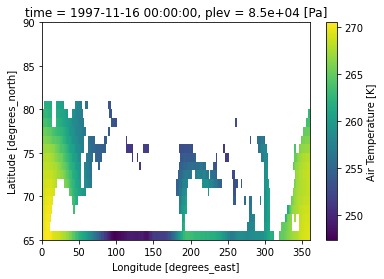

In [18]:
### test reading in and masking on monthly tas 
dir = '/badc/cmip6/data/CMIP6/CMIP/E3SM-Project/E3SM-1-0/historical/r1i1p1f1/Amon/ta/gr/latest/'
mod = 'E3SM-1-0'
ens = 'r1i1p1f1'

f = read_in(dir, t_bnds=inversion_time_period, months=winter_months, plev=True)

f = sea_ice_mask(f, mod, ens, 
                 t_bnds=inversion_time_period, 
                 months=winter_months, reverse=True)

f.isel(time=13).ta.plot()

In [2]:
### cell makes a dataframe containing paths to air temp data (below is just 1st ens mem)

exps = ["historical"]
#exps = ['ssp245']
#exps = ['ssp126']
dirs = []
var_path = "Amon/ta"
#var_path = "SImon/siconca"
for experiment in exps:
    if experiment == "historical":
        exp_set = "CMIP"
    else:
        exp_set = "ScenarioMIP"
    for x in glob.glob('/badc/cmip6/data/CMIP6/{es}/*/*/{e}/r1i*/{v}/*/latest/'.format(es=exp_set, e=experiment, v=var_path)):
        dirs.append(x)
model = []
ensemble_member = []
for dir in dirs:
    model.append(dir.split('/')[7])
    ensemble_member.append(dir.split('/')[9])
#dirs.reverse()
print(len(dirs))
df = pd.DataFrame({'ta_dirs': dirs, 
                   'Model': model,
                   'Ensemble_member': ensemble_member})
df['tas_dirs'] = df['ta_dirs'].str.replace('Amon/ta', 'Amon/tas')
for dir in df['tas_dirs']:
    if not os.path.isdir(dir):
        print('no tas path: {}'.format(dir))


rows_to_drop = []
for ind in df.index:
    dir = df['tas_dirs'][ind]
    if not os.path.isdir(dir):
        rows_to_drop.append(ind)

df.drop(rows_to_drop, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)  

#check for any remaning errors:
for dir in df['tas_dirs']:
    if not os.path.isdir(dir):
        print('drop failed, error on: {}'.format(dir))

print(len(df))

71
71


In [4]:
df

,ta_dirs,Model,Ensemble_member,tas_dirs
0,/badc/cmip6/data/CMIP6/CMIP/AS-RCEC/TaiESM1/hi...,TaiESM1,r1i1p1f1,/badc/cmip6/data/CMIP6/CMIP/AS-RCEC/TaiESM1/hi...
1,/badc/cmip6/data/CMIP6/CMIP/AWI/AWI-CM-1-1-MR/...,AWI-CM-1-1-MR,r1i1p1f1,/badc/cmip6/data/CMIP6/CMIP/AWI/AWI-CM-1-1-MR/...
2,/badc/cmip6/data/CMIP6/CMIP/AWI/AWI-ESM-1-1-LR...,AWI-ESM-1-1-LR,r1i1p1f1,/badc/cmip6/data/CMIP6/CMIP/AWI/AWI-ESM-1-1-LR...
3,/badc/cmip6/data/CMIP6/CMIP/BCC/BCC-CSM2-MR/hi...,BCC-CSM2-MR,r1i1p1f1,/badc/cmip6/data/CMIP6/CMIP/BCC/BCC-CSM2-MR/hi...
4,/badc/cmip6/data/CMIP6/CMIP/BCC/BCC-ESM1/histo...,BCC-ESM1,r1i1p1f1,/badc/cmip6/data/CMIP6/CMIP/BCC/BCC-ESM1/histo...
...,...,...,...,...
66,/badc/cmip6/data/CMIP6/CMIP/NUIST/NESM3/histor...,NESM3,r1i1p1f1,/badc/cmip6/data/CMIP6/CMIP/NUIST/NESM3/histor...
67,/badc/cmip6/data/CMIP6/CMIP/SNU/SAM0-UNICON/hi...,SAM0-UNICON,r1i1p1f1,/badc/cmip6/data/CMIP6/CMIP/SNU/SAM0-UNICON/hi...
68,/badc/cmip6/data/CMIP6/CMIP/THU/CIESM/historic...,CIESM,r1i1p1f1,/badc/cmip6/data/CMIP6/CMIP/THU/CIESM/historic...
69,/badc/cmip6/data/CMIP6/CMIP/UA/MCM-UA-1-0/hist...,MCM-UA-1-0,r1i1p1f1,/badc/cmip6/data/CMIP6/CMIP/UA/MCM-UA-1-0/hist...


In [3]:
### tests processing to inversions on 1 model 

i=50
dir_ta = df['ta_dirs'][i]
dir_tas = df['tas_dirs'][i]
mod = df['Model'][i]
ens = df['Ensemble_member'][i]
#mod_ens = model + ensemble_member
dir_ta


for region in ['sea_ice', 'open_ocean']:
    process_inversions(dir_ta=dir_ta, dir_tas=dir_tas, 
                       region=region, mod=mod, ens=ens)
   

'/badc/cmip6/data/CMIP6/CMIP/CCCma/CanESM5/historical/r24i1p1f1/Amon/ta/gn/latest/'

In [ ]:
### now run over all models:
for i in tqdm(np.arange(len(df))):
    dir_ta = df['ta_dirs'][i]
    dir_tas = df['tas_dirs'][i]
    mod = df['Model'][i]
    ens = df['Ensemble_member'][i]
    for region in ['sea_ice', 'open_ocean']:
        process_inversions(dir_ta=dir_ta, dir_tas=dir_tas,
                           region=region, mod=mod, ens=ens)
   

  0%|          | 0/131 [00:00<?, ?it/s]

In [ ]:
for i in tqdm(np.arange(len(df))):
    dir_ta = df['ta_dirs'][i]
    dir_tas = df['tas_dirs'][i]
    mod = df['Model'][i]
    ens = df['Ensemble_member'][i]
    for region in ['open_ocean']:
        process_inversions(dir_ta=dir_ta, dir_tas=dir_tas,
                           region=region, mod=mod, ens=ens)
   

  0%|          | 0/71 [00:00<?, ?it/s]